In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("lqzmlaq/gopro-large")
print("Path to dataset files:", path)

100%|██████████| 8.89G/8.89G [01:23<00:00, 114MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lqzmlaq/gopro-large/versions/1


In [ ]:
import os

base_path = os.path.join(path, "GOPRO_Large")
dataset_structure = []
for root, dirs, _ in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 4 * level
    dataset_structure.append(f"{indent}{os.path.basename(root)}/")

dataset_structure


['GOPRO_Large/',
 '    test/',
 '        GOPR0410_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0881_11_01/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0871_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0854_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0384_11_05/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0862_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0869_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0385_11_01/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0396_11_00/',
 '            blur_gamma/',
 '            sharp/',
 '            blur/',
 '        GOPR0868_11_00/',
 '            blur_gamma/',
 '  

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
import os

def get_pairs(path, sub_paths):
    pairs = []
    for sub_path in sub_paths:
        filenames = sorted(os.listdir(os.path.join(path, sub_path, "sharp")))
        for filename in filenames:
            pairs.append((sub_path, filename))
    return pairs

train_path = os.path.join(path, "GOPRO_Large/train")
sub_paths = [sub for sub in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, sub))]
all_pairs = get_pairs(train_path, sub_paths)
train_pairs, val_pairs = train_test_split(all_pairs, test_size=0.2, random_state=42)



In [ ]:
def data_generator(path, pair_list, image_size):
    for sub_path, filename in pair_list:
        sharp_path = os.path.join(path, sub_path, "sharp", filename)
        blur_path = os.path.join(path, sub_path, "blur", filename)

        sharp = cv2.imread(sharp_path, cv2.IMREAD_COLOR)
        blur = cv2.imread(blur_path, cv2.IMREAD_COLOR)

        sharp = cv2.resize(sharp, (image_size, image_size))
        blur = cv2.resize(blur, (image_size, image_size))

        sharp = sharp / 255.0
        blur = blur / 255.0

        yield blur, sharp


In [ ]:
def create_tf_dataset(path, pair_list, image_size, batch_size=16, shuffle_buffer=1000):

    generator = lambda: data_generator(path, pair_list, image_size)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(image_size, image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(image_size, image_size, 3), dtype=tf.float32)
        )
    )

    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
image_size = 224
batch_size = 16

train_dataset = create_tf_dataset(train_path, train_pairs, image_size, batch_size)
val_dataset = create_tf_dataset(train_path, val_pairs, image_size, batch_size)


In [ ]:
for batch in train_dataset.take(1):
    blur, sharp = batch
    print(f"Blur image shape: {blur.shape}")
    print(f"Sharp image shape: {sharp.shape}")

# **Autoencoder model**

In [ ]:
def residual_block(x, f):
    skip = x
    for _ in range(2):
        x = layers.Conv2D(f, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
    if K.int_shape(skip)[-1] != f:
        skip = layers.Conv2D(f, 1, padding='same')(skip)
    return layers.LeakyReLU(0.2)(layers.Add()([x, skip]))

def attention_block(x, g, f):
    if K.int_shape(x)[1] != K.int_shape(g)[1] or K.int_shape(x)[2] != K.int_shape(g)[2]:
      x = layers.UpSampling2D(size=(2, 2))(x)
    theta = layers.Conv2D(f, 1, padding='same')(x)
    phi = layers.Conv2D(f, 1, padding='same')(g)
    psi = layers.Conv2D(1, 1, padding='same')(layers.Activation('relu')(layers.Add()([theta, phi])))
    return layers.Multiply()([x, layers.Activation('sigmoid')(psi)])

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    init = x

    skips = []
    filters = [64, 128, 256, 512]
    for f in filters:
        x = layers.Conv2D(f, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = residual_block(x, f)
        skips.append(x)

    for rate in [2, 4]:
        x = layers.Conv2D(512, 3, dilation_rate=rate, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    for f, skip in zip(reversed(filters), reversed(skips)):
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        att = attention_block(skip, x, f)
        x = layers.Concatenate()([x, att])
        x = layers.Conv2D(f, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = residual_block(x, f)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Add()([x, init])
    outputs = layers.Conv2D(input_shape[-1], 3, padding='same', activation='tanh')(x)
    outputs = layers.Lambda(lambda x: (x + 1) / 2)(outputs)

    return Model(inputs, outputs, name="autoencoder")

autoencoder = build_model()


In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=10,
                               min_lr=0.00001)

In [ ]:
from tensorflow.image import psnr, ssim

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(psnr(y_true, y_pred, max_val=1.0))

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = ssim_loss(y_true, y_pred)
    return mse + ssim

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in ['block1_conv2', 'block2_conv2', 'block3_conv3']]
feature_extractor = Model(inputs=vgg.input, outputs=outputs)
def perceptual_loss(y_true, y_pred):
    true_features = feature_extractor(y_true)
    pred_features = feature_extractor(y_pred)

    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    perceptual = tf.add_n([tf.reduce_mean(tf.square(tf_feat - pr_feat))
                           for tf_feat, pr_feat in zip(true_features, pred_features)])

    return loss + 0.001 * perceptual

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
autoencoder.compile(optimizer=opt, loss=perceptual_loss, metrics=[psnr_metric, ssim_metric])
autoencoder.summary()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Datasets/autoencoder_checkpoint.h5',
    save_best_only=True,
    monitor='val_psnr_metric',
    mode='max',
    save_weights_only=False
)

callbacks = [lr_reducer, checkpoint_cb]
autoencoder.fit(train_dataset,
                validation_data=val_dataset,
                epochs=100,
                callbacks=callbacks)

Epoch 1/100
    106/Unknown 373s 2s/step - loss: 0.0561 - psnr_metric: 17.2071 - ssim_metric: 0.4843

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - loss: 0.0559 - psnr_metric: 17.2340 - ssim_metric: 0.4854 - val_loss: 0.0807 - val_psnr_metric: 13.2951 - val_ssim_metric: 0.3787 - learning_rate: 2.0000e-04
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0135 - psnr_metric: 22.8994 - ssim_metric: 0.7245

106/106 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - loss: 0.0135 - psnr_metric: 22.9023 - ssim_metric: 0.7246 - val_loss: 0.0559 - val_psnr_metric: 14.7704 - val_ssim_metric: 0.4986 - learning_rate: 2.0000e-04
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0116 - psnr_metric: 23.7139 - ssim_metric: 0.7642

106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - loss: 0.0116 - psnr_metric: 23.7148 - ssim_metric: 0.7642 - val_loss: 0.0324 - val_psnr_metric: 17.2207 - val_ssim_metric: 0.6312 - learning_rate: 2.0000e-04
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0111 - psnr_metric: 24.0657 - ssim_metric: 0.7771

106/106 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - loss: 0.0111 - psnr_metric: 24.0661 - ssim_metric: 0.7771 - val_loss: 0.0170 - val_psnr_metric: 20.6087 - val_ssim_metric: 0.7400 - learning_rate: 2.0000e-04
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0112 - psnr_metric: 24.1258 - ssim_metric: 0.7817

106/106 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 0.0112 - psnr_metric: 24.1272 - ssim_metric: 0.7817 - val_loss: 0.0114 - val_psnr_metric: 23.2865 - val_ssim_metric: 0.7867 - learning_rate: 2.0000e-04
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0107 - psnr_metric: 24.4613 - ssim_metric: 0.7853

106/106 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - loss: 0.0107 - psnr_metric: 24.4619 - ssim_metric: 0.7853 - val_loss: 0.0101 - val_psnr_metric: 24.6177 - val_ssim_metric: 0.7998 - learning_rate: 2.0000e-04
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0104 - psnr_metric: 24.5899 - ssim_metric: 0.7918

106/106 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - loss: 0.0104 - psnr_metric: 24.5899 - ssim_metric: 0.7918 - val_loss: 0.0094 - val_psnr_metric: 25.1663 - val_ssim_metric: 0.8098 - learning_rate: 2.0000e-04
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - loss: 0.0101 - psnr_metric: 24.8326 - ssim_metric: 0.7957 - val_loss: 0.0107 - val_psnr_metric: 23.6828 - val_ssim_metric: 0.8043 - learning_rate: 2.0000e-04
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0104 - psnr_metric: 24.7026 - ssim_metric: 0.7935

106/106 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - loss: 0.0104 - psnr_metric: 24.7037 - ssim_metric: 0.7935 - val_loss: 0.0093 - val_psnr_metric: 25.0423 - val_ssim_metric: 0.8154 - learning_rate: 2.0000e-04
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - loss: 0.0103 - psnr_metric: 24.7664 - ssim_metric: 0.7949 - val_loss: 0.0116 - val_psnr_metric: 23.6667 - val_ssim_metric: 0.8146 - learning_rate: 2.0000e-04
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - loss: 0.0099 - psnr_metric: 24.9316 - ssim_metric: 0.8005 - val_loss: 0.0099 - val_psnr_metric: 24.6264 - val_ssim_metric: 0.8135 - learning_rate: 2.0000e-04
Epoch 12/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0099 - psnr_metric: 24.8975 - ssim_metric: 0.7987

106/106 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - loss: 0.0099 - psnr_metric: 24.8973 - ssim_metric: 0.7986 - val_loss: 0.0092 - val_psnr_metric: 25.2185 - val_ssim_metric: 0.8154 - learning_rate: 2.0000e-04
Epoch 13/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - loss: 0.0099 - psnr_metric: 24.8277 - ssim_metric: 0.7980 - val_loss: 0.0096 - val_psnr_metric: 24.9583 - val_ssim_metric: 0.8184 - learning_rate: 2.0000e-04
Epoch 14/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0097 - psnr_metric: 25.0378 - ssim_metric: 0.8002

106/106 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - loss: 0.0097 - psnr_metric: 25.0371 - ssim_metric: 0.8002 - val_loss: 0.0086 - val_psnr_metric: 25.7795 - val_ssim_metric: 0.8227 - learning_rate: 2.0000e-04
Epoch 15/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 0.0096 - psnr_metric: 25.0501 - ssim_metric: 0.8019 - val_loss: 0.0093 - val_psnr_metric: 24.9437 - val_ssim_metric: 0.8213 - learning_rate: 2.0000e-04
Epoch 16/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0096 - psnr_metric: 24.9230 - ssim_metric: 0.7986

106/106 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - loss: 0.0096 - psnr_metric: 24.9238 - ssim_metric: 0.7986 - val_loss: 0.0084 - val_psnr_metric: 25.6301 - val_ssim_metric: 0.8231 - learning_rate: 2.0000e-04
Epoch 17/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - loss: 0.0091 - psnr_metric: 25.1190 - ssim_metric: 0.8072 - val_loss: 0.0085 - val_psnr_metric: 25.6788 - val_ssim_metric: 0.8240 - learning_rate: 2.0000e-04
Epoch 18/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0091 - psnr_metric: 25.0794 - ssim_metric: 0.8056

106/106 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 0.0091 - psnr_metric: 25.0788 - ssim_metric: 0.8055 - val_loss: 0.0083 - val_psnr_metric: 25.7215 - val_ssim_metric: 0.8195 - learning_rate: 2.0000e-04
Epoch 19/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - loss: 0.0091 - psnr_metric: 25.1242 - ssim_metric: 0.8026 - val_loss: 0.0086 - val_psnr_metric: 25.3543 - val_ssim_metric: 0.8162 - learning_rate: 2.0000e-04
Epoch 20/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - loss: 0.0092 - psnr_metric: 24.9985 - ssim_metric: 0.8009 - val_loss: 0.0105 - val_psnr_metric: 23.8527 - val_ssim_metric: 0.8052 - learning_rate: 2.0000e-04
Epoch 21/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - loss: 0.0109 - psnr_metric: 24.3065 - ssim_metric: 0.7920 - val_loss: 0.0113 - val_psnr_metric: 24.0082 - val_ssim_metric: 0.7971 - learning_rate: 2.0000e-04
Epoch 22/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - loss: 0.0095 - psnr_metric: 24.9515 - ssim_metric: 0.8029 - val_loss: 0.0088 - val_psnr_metric: 

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

autoencoder = load_model("/content/drive/MyDrive/Datasets/autoencoder_checkpoint.h5", compile=False)
autoencoder.compile(optimizer=opt, loss=perceptual_loss, metrics=[psnr_metric, ssim_metric])

callbacks = [lr_reducer, checkpoint_cb]
autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    initial_epoch=50,
    epochs=100,
    callbacks=callbacks
)

Epoch 51/100
    106/Unknown 349s 2s/step - loss: 0.0080 - psnr_metric: 25.4251 - ssim_metric: 0.8152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - loss: 0.0080 - psnr_metric: 25.4257 - ssim_metric: 0.8152 - val_loss: 0.0097 - val_psnr_metric: 24.6685 - val_ssim_metric: 0.7977 - learning_rate: 2.0000e-04
Epoch 52/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - loss: 0.0081 - psnr_metric: 25.4655 - ssim_metric: 0.8143 - val_loss: 0.0169 - val_psnr_metric: 22.5697 - val_ssim_metric: 0.7579 - learning_rate: 2.0000e-04
Epoch 53/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0083 - psnr_metric: 25.3989 - ssim_metric: 0.8073

106/106 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - loss: 0.0083 - psnr_metric: 25.4005 - ssim_metric: 0.8074 - val_loss: 0.0081 - val_psnr_metric: 25.5026 - val_ssim_metric: 0.8132 - learning_rate: 2.0000e-04
Epoch 54/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 0.0079 - psnr_metric: 25.5001 - ssim_metric: 0.8148 - val_loss: 0.0089 - val_psnr_metric: 25.0047 - val_ssim_metric: 0.8188 - learning_rate: 2.0000e-04
Epoch 55/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - loss: 0.0079 - psnr_metric: 25.4660 - ssim_metric: 0.8179 - val_loss: 0.0098 - val_psnr_metric: 24.3419 - val_ssim_metric: 0.7978 - learning_rate: 2.0000e-04
Epoch 56/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 0.0079 - psnr_metric: 25.3915 - ssim_metric: 0.8145 - val_loss: 0.0088 - val_psnr_metric: 25.2977 - val_ssim_metric: 0.8103 - learning_rate: 2.0000e-04
Epoch 57/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0077 - psnr_metric: 25.4813 - ssim_metric: 0.8177

106/106 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - loss: 0.0077 - psnr_metric: 25.4820 - ssim_metric: 0.8177 - val_loss: 0.0082 - val_psnr_metric: 25.5402 - val_ssim_metric: 0.8196 - learning_rate: 2.0000e-04
Epoch 58/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - loss: 0.0079 - psnr_metric: 25.4286 - ssim_metric: 0.8150 - val_loss: 0.0082 - val_psnr_metric: 25.3545 - val_ssim_metric: 0.8162 - learning_rate: 2.0000e-04
Epoch 59/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 0.0075 - psnr_metric: 25.7483 - ssim_metric: 0.8202 - val_loss: 0.0085 - val_psnr_metric: 25.0953 - val_ssim_metric: 0.8264 - learning_rate: 2.0000e-04
Epoch 60/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0075 - psnr_metric: 25.6123 - ssim_metric: 0.8242 - val_loss: 0.0085 - val_psnr_metric: 24.9100 - val_ssim_metric: 0.8183 - learning_rate: 2.0000e-04
Epoch 61/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 0.0076 - psnr_metric: 25.5729 - ssim_metric: 0.8189 - val_loss: 0.0088 - val_psnr_metric: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - loss: 0.0077 - psnr_metric: 25.6467 - ssim_metric: 0.8180 - val_loss: 0.0090 - val_psnr_metric: 25.6938 - val_ssim_metric: 0.8143 - learning_rate: 1.0000e-04
Epoch 65/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0082 - psnr_metric: 25.4107 - ssim_metric: 0.8117

106/106 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - loss: 0.0082 - psnr_metric: 25.4128 - ssim_metric: 0.8118 - val_loss: 0.0074 - val_psnr_metric: 26.0245 - val_ssim_metric: 0.8243 - learning_rate: 1.0000e-04
Epoch 66/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 0.0074 - psnr_metric: 25.7484 - ssim_metric: 0.8208 - val_loss: 0.0074 - val_psnr_metric: 25.8692 - val_ssim_metric: 0.8248 - learning_rate: 1.0000e-04
Epoch 67/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0074 - psnr_metric: 25.7530 - ssim_metric: 0.8187

106/106 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - loss: 0.0074 - psnr_metric: 25.7539 - ssim_metric: 0.8188 - val_loss: 0.0070 - val_psnr_metric: 26.2290 - val_ssim_metric: 0.8277 - learning_rate: 1.0000e-04
Epoch 68/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - loss: 0.0074 - psnr_metric: 25.6365 - ssim_metric: 0.8200 - val_loss: 0.0074 - val_psnr_metric: 25.5939 - val_ssim_metric: 0.8259 - learning_rate: 1.0000e-04
Epoch 69/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 0.0072 - psnr_metric: 25.8440 - ssim_metric: 0.8229 - val_loss: 0.0084 - val_psnr_metric: 25.0537 - val_ssim_metric: 0.8151 - learning_rate: 1.0000e-04
Epoch 70/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - loss: 0.0075 - psnr_metric: 25.6421 - ssim_metric: 0.8172 - val_loss: 0.0082 - val_psnr_metric: 25.4627 - val_ssim_metric: 0.8141 - learning_rate: 1.0000e-04
Epoch 71/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - loss: 0.0074 - psnr_metric: 25.7789 - ssim_metric: 0.8219 - val_loss: 0.0073 - val_psnr_metric: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - loss: 0.0069 - psnr_metric: 25.9695 - ssim_metric: 0.8261 - val_loss: 0.0068 - val_psnr_metric: 26.4083 - val_ssim_metric: 0.8294 - learning_rate: 1.0000e-04
Epoch 74/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - loss: 0.0070 - psnr_metric: 25.9305 - ssim_metric: 0.8249 - val_loss: 0.0072 - val_psnr_metric: 25.9416 - val_ssim_metric: 0.8266 - learning_rate: 1.0000e-04
Epoch 75/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - loss: 0.0068 - psnr_metric: 26.0655 - ssim_metric: 0.8319 - val_loss: 0.0076 - val_psnr_metric: 25.3870 - val_ssim_metric: 0.8238 - learning_rate: 1.0000e-04
Epoch 76/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - loss: 0.0070 - psnr_metric: 25.8720 - ssim_metric: 0.8264 - val_loss: 0.0082 - val_psnr_metric: 25.4047 - val_ssim_metric: 0.8211 - learning_rate: 1.0000e-04
Epoch 77/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - loss: 0.0071 - psnr_metric: 25.8746 - ssim_metric: 0.8245 - val_loss: 0.0079 - val_psnr_metric: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - loss: 0.0068 - psnr_metric: 26.0875 - ssim_metric: 0.8302 - val_loss: 0.0065 - val_psnr_metric: 26.5091 - val_ssim_metric: 0.8353 - learning_rate: 5.0000e-05
Epoch 85/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - loss: 0.0067 - psnr_metric: 25.9835 - ssim_metric: 0.8282 - val_loss: 0.0067 - val_psnr_metric: 26.2428 - val_ssim_metric: 0.8329 - learning_rate: 5.0000e-05
Epoch 86/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - loss: 0.0066 - psnr_metric: 26.2173 - ssim_metric: 0.8324 - val_loss: 0.0066 - val_psnr_metric: 26.4395 - val_ssim_metric: 0.8295 - learning_rate: 5.0000e-05
Epoch 87/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0065 - psnr_metric: 26.1983 - ssim_metric: 0.8334

106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - loss: 0.0065 - psnr_metric: 26.1990 - ssim_metric: 0.8334 - val_loss: 0.0065 - val_psnr_metric: 26.5108 - val_ssim_metric: 0.8360 - learning_rate: 5.0000e-05
Epoch 88/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - loss: 0.0064 - psnr_metric: 26.2673 - ssim_metric: 0.8341 - val_loss: 0.0067 - val_psnr_metric: 26.4053 - val_ssim_metric: 0.8337 - learning_rate: 5.0000e-05
Epoch 89/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 0.0065 - psnr_metric: 26.1273 - ssim_metric: 0.8316 - val_loss: 0.0069 - val_psnr_metric: 26.2401 - val_ssim_metric: 0.8326 - learning_rate: 5.0000e-05
Epoch 90/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0065 - psnr_metric: 26.1972 - ssim_metric: 0.8314

106/106 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - loss: 0.0065 - psnr_metric: 26.1982 - ssim_metric: 0.8314 - val_loss: 0.0066 - val_psnr_metric: 26.5423 - val_ssim_metric: 0.8339 - learning_rate: 5.0000e-05
Epoch 91/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - loss: 0.0063 - psnr_metric: 26.4522 - ssim_metric: 0.8370 - val_loss: 0.0066 - val_psnr_metric: 26.3261 - val_ssim_metric: 0.8327 - learning_rate: 5.0000e-05
Epoch 92/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0065 - psnr_metric: 26.1554 - ssim_metric: 0.8356

106/106 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - loss: 0.0065 - psnr_metric: 26.1567 - ssim_metric: 0.8356 - val_loss: 0.0063 - val_psnr_metric: 26.6215 - val_ssim_metric: 0.8377 - learning_rate: 5.0000e-05
Epoch 93/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - loss: 0.0064 - psnr_metric: 26.2838 - ssim_metric: 0.8336 - val_loss: 0.0071 - val_psnr_metric: 26.1525 - val_ssim_metric: 0.8294 - learning_rate: 5.0000e-05
Epoch 94/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - loss: 0.0064 - psnr_metric: 26.2454 - ssim_metric: 0.8350 - val_loss: 0.0086 - val_psnr_metric: 25.2063 - val_ssim_metric: 0.8076 - learning_rate: 5.0000e-05
Epoch 95/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 0.0066 - psnr_metric: 26.1117 - ssim_metric: 0.8319 - val_loss: 0.0065 - val_psnr_metric: 26.4397 - val_ssim_metric: 0.8346 - learning_rate: 5.0000e-05
Epoch 96/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 0.0063 - psnr_metric: 26.4037 - ssim_metric: 0.8368 - val_loss: 0.0065 - val_psnr_metric: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - loss: 0.0063 - psnr_metric: 26.3757 - ssim_metric: 0.8357 - val_loss: 0.0063 - val_psnr_metric: 26.6583 - val_ssim_metric: 0.8350 - learning_rate: 5.0000e-05
Epoch 100/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - loss: 0.0062 - psnr_metric: 26.3154 - ssim_metric: 0.8374 - val_loss: 0.0067 - val_psnr_metric: 26.5046 - val_ssim_metric: 0.8347 - learning_rate: 5.0000e-05


In [1]:
model = keras.models.load_model('/content/drive/MyDrive/Datasets/autoencoder_checkpoint.h5', compile=False)

model.compile(optimizer=opt, loss=perceptual_loss, metrics=[psnr_metric, ssim_metric])

results = model.evaluate(val_dataset)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation PSNR: {results[1]:.4f}")
print(f"Validation SSIM: {results[2]:.4f}")

test_path = os.path.join(path, "GOPRO_Large/test")
test_sub_paths = [sub for sub in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, sub))]

test_pairs = get_pairs(test_path, test_sub_paths)
test_dataset = create_tf_dataset(test_path, test_pairs, image_size, batch_size)
for batch in test_dataset.take(1):
    x_test, y_test = batch
    preds = model.predict(x_test)

    n = 5
    random_indices = np.random.choice(range(x_test.shape[0]), size=n, replace=False)
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(random_indices):
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(tf.clip_by_value(x_test[idx], 0, 1))
        plt.title('Blurred Input')
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(tf.clip_by_value(y_test[idx], 0, 1))
        plt.title('Sharp Ground Truth')
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(tf.clip_by_value(preds[idx], 0, 1))
        plt.title('Predicted Output')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


NameError: name 'keras' is not defined

1 image predict


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


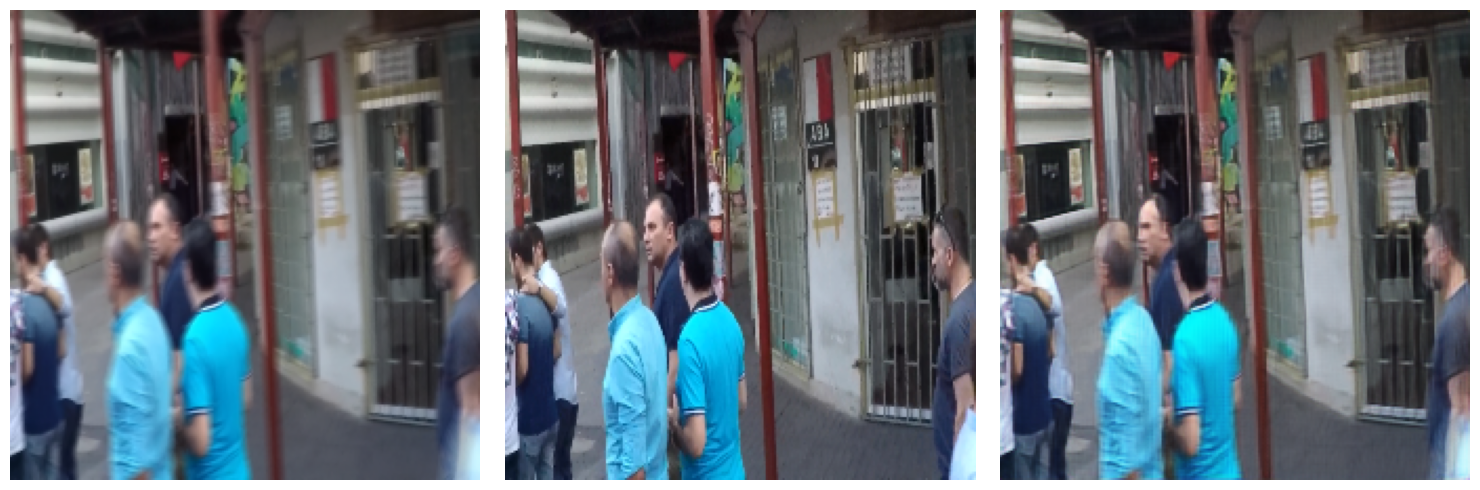

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Datasets/autoencoder_checkpoint.h5', compile=False)
model.compile(optimizer=opt, loss=perceptual_loss, metrics=[psnr_metric, ssim_metric])

# results = model.evaluate(val_dataset)
# print(f"Validation Loss: {results[0]:.4f}")
# print(f"Validation PSNR: {results[1]:.4f}")
# print(f"Validation SSIM: {results[2]:.4f}")

def plot_single_image(blur_image_path, sharp_image_path, image_size):
    image_blurred = cv2.imread(blur_image_path, cv2.IMREAD_COLOR)
    image_blurred = cv2.resize(image_blurred, (image_size, image_size))
    image_blurred = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB)
    image_blurred = image_blurred / 255.0

    image_sharp = cv2.imread(sharp_image_path, cv2.IMREAD_COLOR)
    image_sharp = cv2.resize(image_sharp, (image_size, image_size))
    image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2RGB)
    image_sharp = image_sharp / 255.0

    pred = model.predict(tf.expand_dims(image_blurred, axis=0))
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(image_blurred)
    # plt.title('Input Image (Blurred)')
    plt.axis('off')

    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(image_sharp)
    # plt.title('Ground Truth (Sharp)')
    plt.axis('off')

    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(tf.clip_by_value(pred[0], 0, 1))
    # plt.title('Predicted Output')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Datasets/plotting_3.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(tf.clip_by_value(pred[0], 0, 1))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Datasets/predicted_only_3.pdf', format='pdf')
    plt.close()


blur_image_path = os.path.join(path, "GOPRO_Large/test/GOPR0385_11_01/blur/003011.png")
sharp_image_path = os.path.join(path, "GOPRO_Large/test/GOPR0385_11_01/sharp/003011.png")
plot_single_image(blur_image_path, sharp_image_path, image_size=224)
